In [3]:

# run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
# load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'


loaded my modules
loaded my own functions


In [5]:
### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)

loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [7]:
### Set file names
runningLocation = 'local'
if  runningLocation== 'local':
    hisFilePath='../data/raw/'
    truthFilePath='../data/raw/' # Truth file settings
elif runningLocation == 'gdata':
    hisFilePath='/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/'
    truthFilePath='/g/data/fu5/deg581/EAC_2yr_ObsVerification_HighRes/output/' # Truth file settings

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'

outFigurePath='../cache/out/'

In [39]:
# define function for calculating spatial mean
def indexMeanMetric(input,iRange,jRange):
    iRange=range(iRange[0],iRange[1]+1)
    jRange=range(jRange[0],jRange[1]+1)
    output = input.isel(eta_rho=iRange, xi_rho=jRange).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output


### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def simple_spatial_plot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
    ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)   
    # plt.tight_layout()


In [11]:
iRangeMetric = [115, 200]
jRangeMetric = [85, 150]
timeRange = [8005, 8013]
timePeriod = 4

In [13]:
### Open truth file
OverlappedTruthFiles = 'yes'
if OverlappedTruthFiles == 'yes':
    truth = loadOverlappedNetcdf(truthFilePath,prefixTruth,filestring='0800[5-9].nc',overlapDays=7)
elif OverlappedTruthFiles == 'no':
    import glob
    chunks = {'ocean_time':1}

    filelist = sorted(glob.glob(truthFilePath+prefixTruth+'0800*.nc'))
    #datelist = np.array(range(timeRange[0],timeRange[1],4))

    for files in filelist: 
        print(files)
        # filelist.append(files)
    truth = xr.open_mfdataset(filelist,chunks, data_vars='minimal',compat='override',coords='minimal',parallel=True, join='right') 
    # truth = dropDuplicateTimes(truth)

loaded from ../data/raw/outer_his_08005.nc to ../data/raw/outer_his_08009.nc


In [15]:
import glob
chunks = {'ocean_time':1}
# filelist = glob.glob(hisFilePath+'roms_fwd_outer1_0800*.nc')


datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth   =truthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    # sst=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()

    if dates == datelist[0]:
        ssh_metricForecast = indexMeanMetric(sshForecast, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
        ssh_metricAnalysis = indexMeanMetric(sshAnalysis, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
        ssh_metricTruth = indexMeanMetric(sshTruth, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))

        sst_metricForecast = indexMeanMetric(sstForecast, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
        sst_metricAnalysis = indexMeanMetric(sstAnalysis, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
    elif dates != datelist[0]:
        temp = indexMeanMetric(sshForecast, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
        ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
        temp = indexMeanMetric(sshAnalysis, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
        ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
        temp = indexMeanMetric(sshTruth, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
        ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
        temp = indexMeanMetric(sstForecast, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
        sst_metricForecast = xr.merge([sst_metricForecast, temp])
        temp = indexMeanMetric(sstAnalysis, iRange=range(iRangeMetric[0],iRangeMetric[1]), jRange=range(jRangeMetric[0],jRangeMetric[1])).to_dataset(name = str(dates))
        sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])


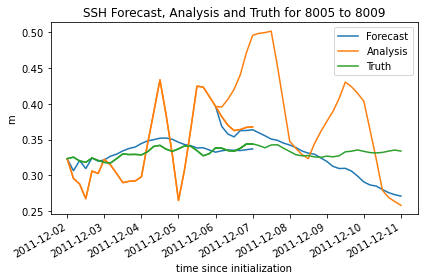

In [19]:
assimPeriod = datelist
ssh_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
ssh_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
ssh_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
for assimPeriod in datelist[1:]:
    ssh_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    ssh_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    ssh_metricTruth[str(assimPeriod)].plot.line("C2",label='')
plt.legend()
plt.title('SSH Forecast, Analysis and Truth for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

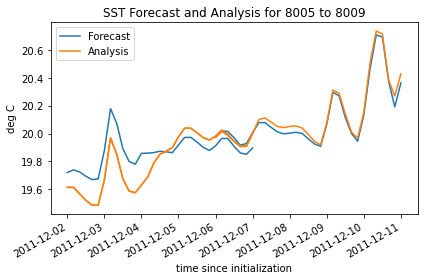

In [21]:
assimPeriod = datelist
sst_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
sst_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
for assimPeriod in datelist[1:]:
    sst_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    sst_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
plt.legend()
plt.title('SST Forecast and Analysis for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('deg C')
plt.tight_layout()

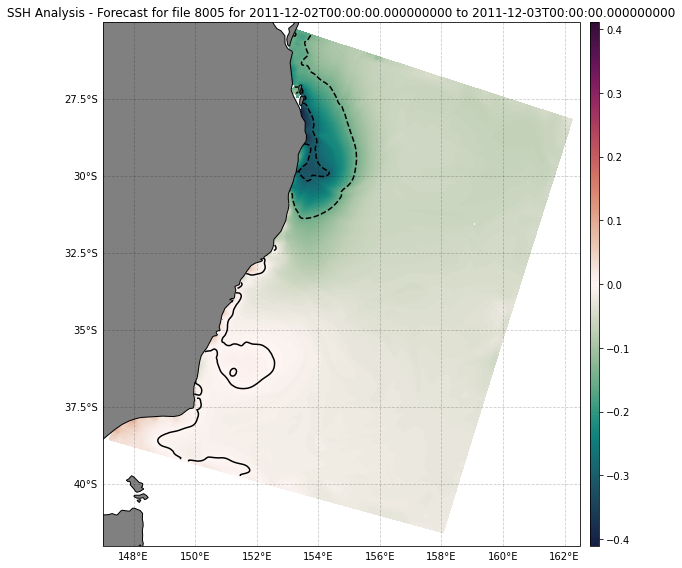

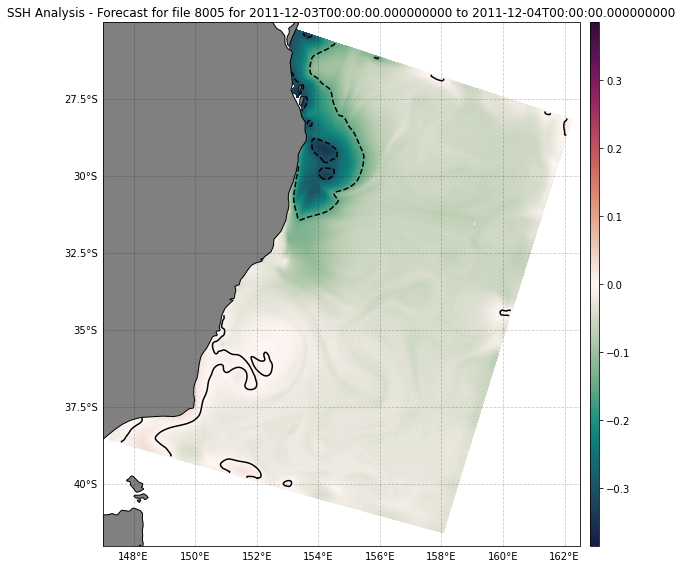

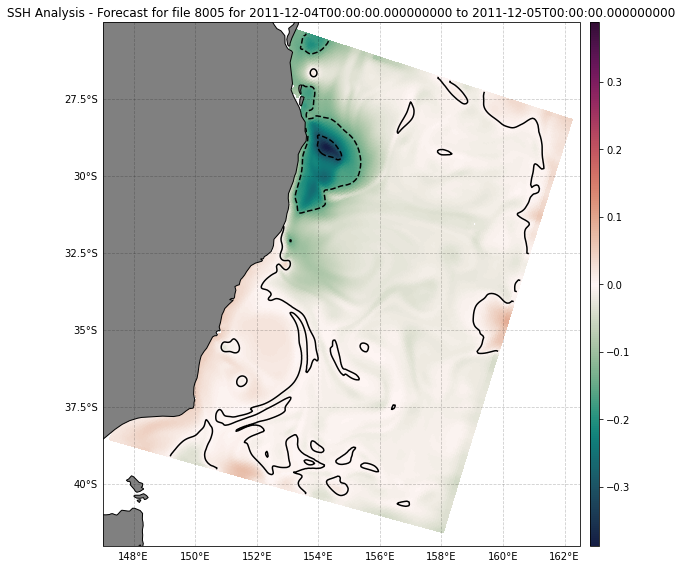

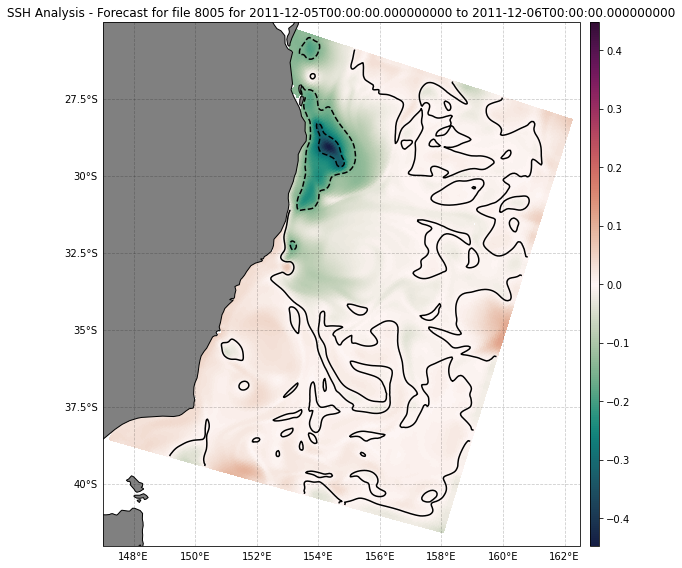

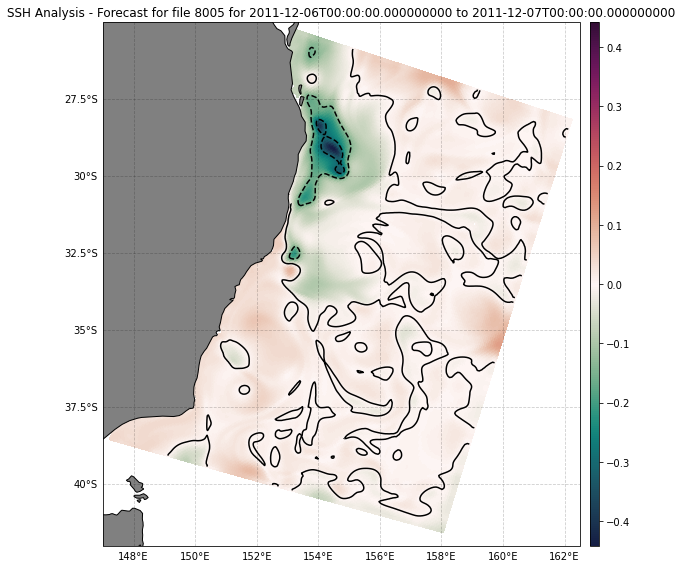

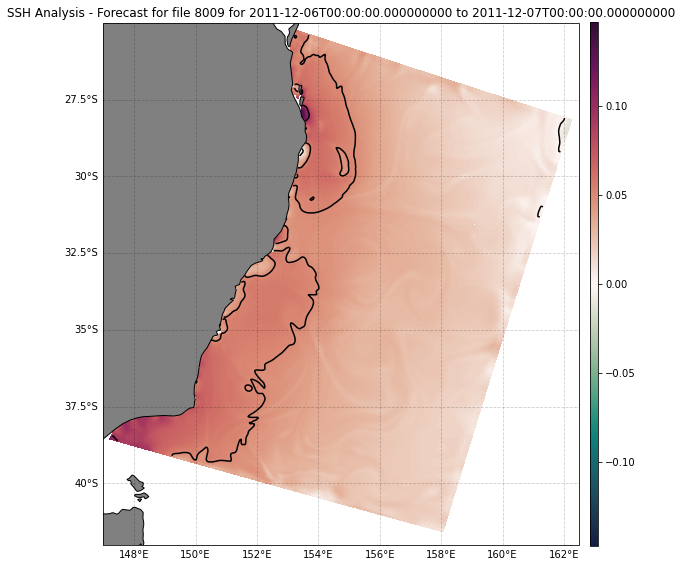

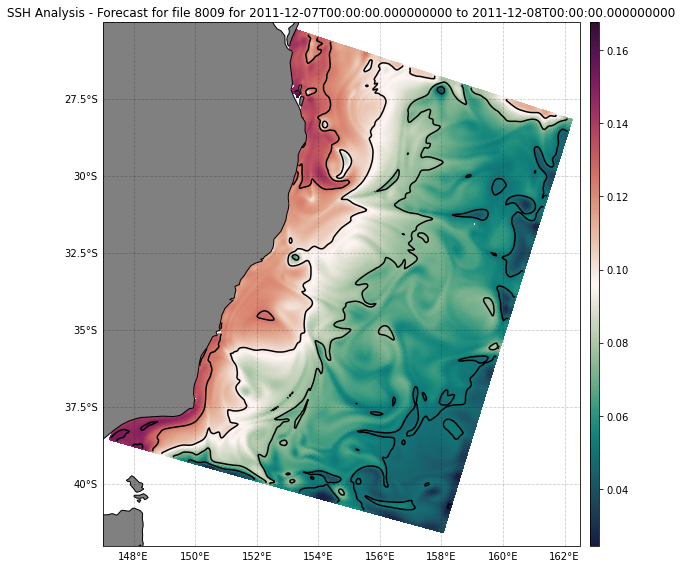

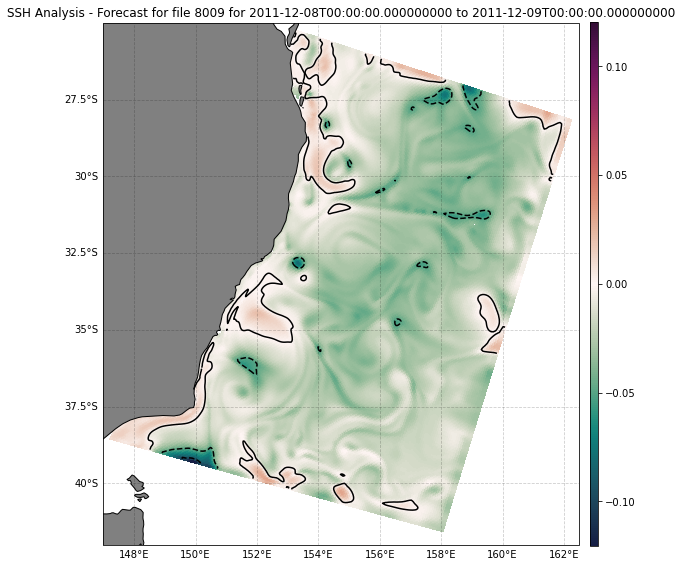

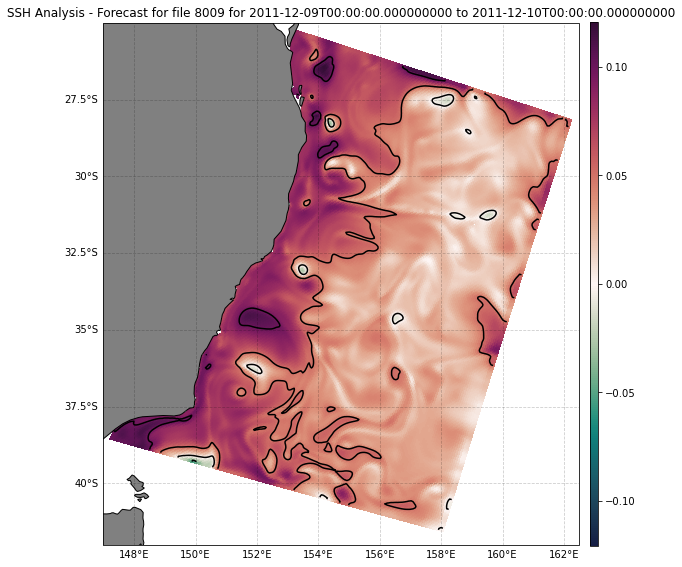

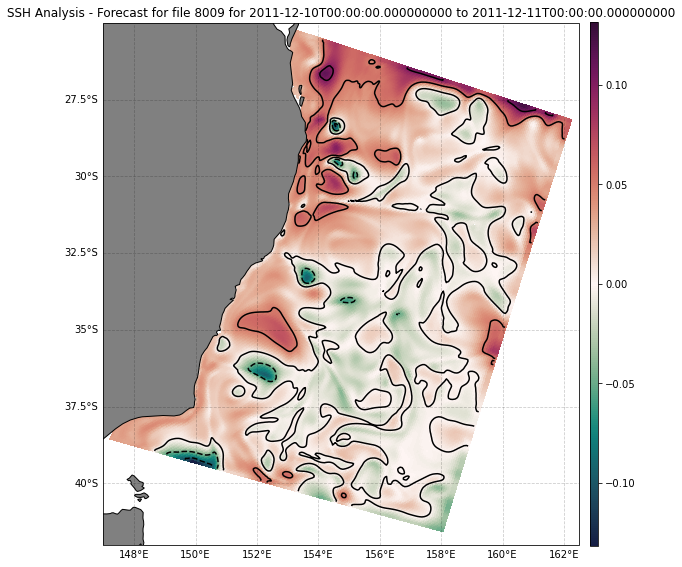

In [48]:
iRangeMetric = [115, 200]
jRangeMetric = [85, 150]
timeRange = [8005, 8013]
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

import glob
chunks = {'ocean_time':1}
# filelist = glob.glob(hisFilePath+'roms_fwd_outer1_0800*.nc')

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisFilePath+prefixAnalysis+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
#     sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
#     sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()

    for tChunk in range(0,timeOutputMax,timeOutputs):
        ## plot of mean difference over days
        toPlotData = xr.concat((sshForecast,sshAnalysis),'diff').diff(dim='diff').isel(diff=0).isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        toPlotData

        fig = plt.figure(figsize=(8,8))
        ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
        ax.set_extent([147, 162.5, -42, -25])

        #ax.coastlines(resolution='50m')
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')

        # cbar_ax = fig.add_axes([0.09, 0.06, 0.84, 0.02])
        # fig.colorbar(im, cax=cbar_ax)
        plt.colorbar(im, pad=0.02, fraction=0.05, aspect=60)

        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
        gl.right_labels = False
        gl.top_labels = False

        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        plt.title('SSH Analysis - Forecast for file '+str(dates)+' for '+date1+' to '+date2)
        plt.ylabel('deg C')
        plt.tight_layout()
        figName = outFigurePath+'SSHdiff_'+str(dates)+'_day'+str(int(tChunk/timeOutputs+1))+'.png'
        plt.savefig(figName,format='png',bbox_inches='tight')

< GeoAxes: <cartopy.crs.PlateCarree object at 0x7faffe596270> >
< GeoAxes: <cartopy.crs.PlateCarree object at 0x7faffe596270> >
< GeoAxes: <cartopy.crs.PlateCarree object at 0x7faffe596270> >
< GeoAxes: <cartopy.crs.PlateCarree object at 0x7faffe596270> >
< GeoAxes: <cartopy.crs.PlateCarree object at 0x7faffe596270> >
< GeoAxes: <cartopy.crs.PlateCarree object at 0x7fafd58de860> >
< GeoAxes: <cartopy.crs.PlateCarree object at 0x7fafd58de860> >
< GeoAxes: <cartopy.crs.PlateCarree object at 0x7fafd58de860> >
< GeoAxes: <cartopy.crs.PlateCarree object at 0x7fafd58de860> >
< GeoAxes: <cartopy.crs.PlateCarree object at 0x7fafd58de860> >


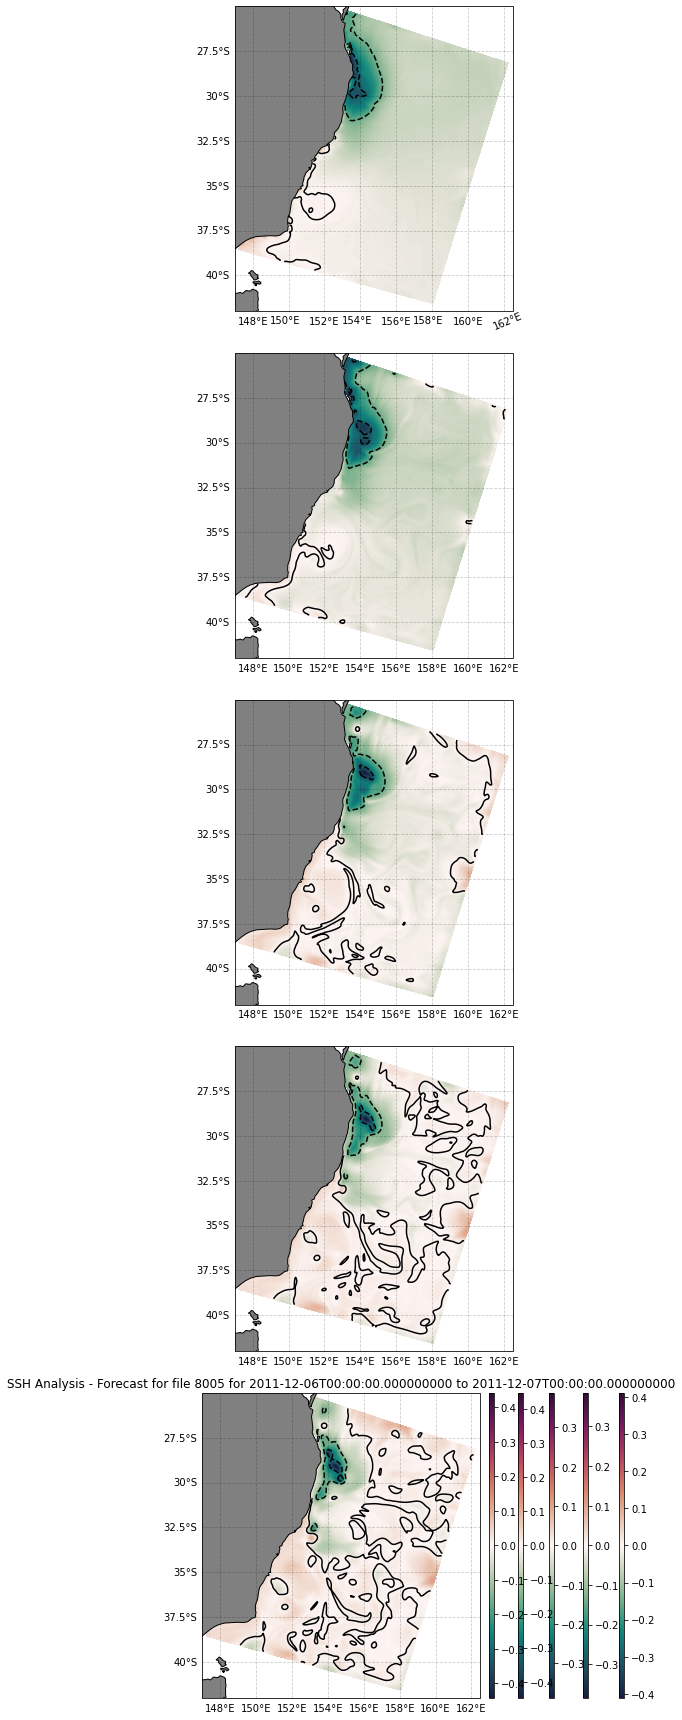

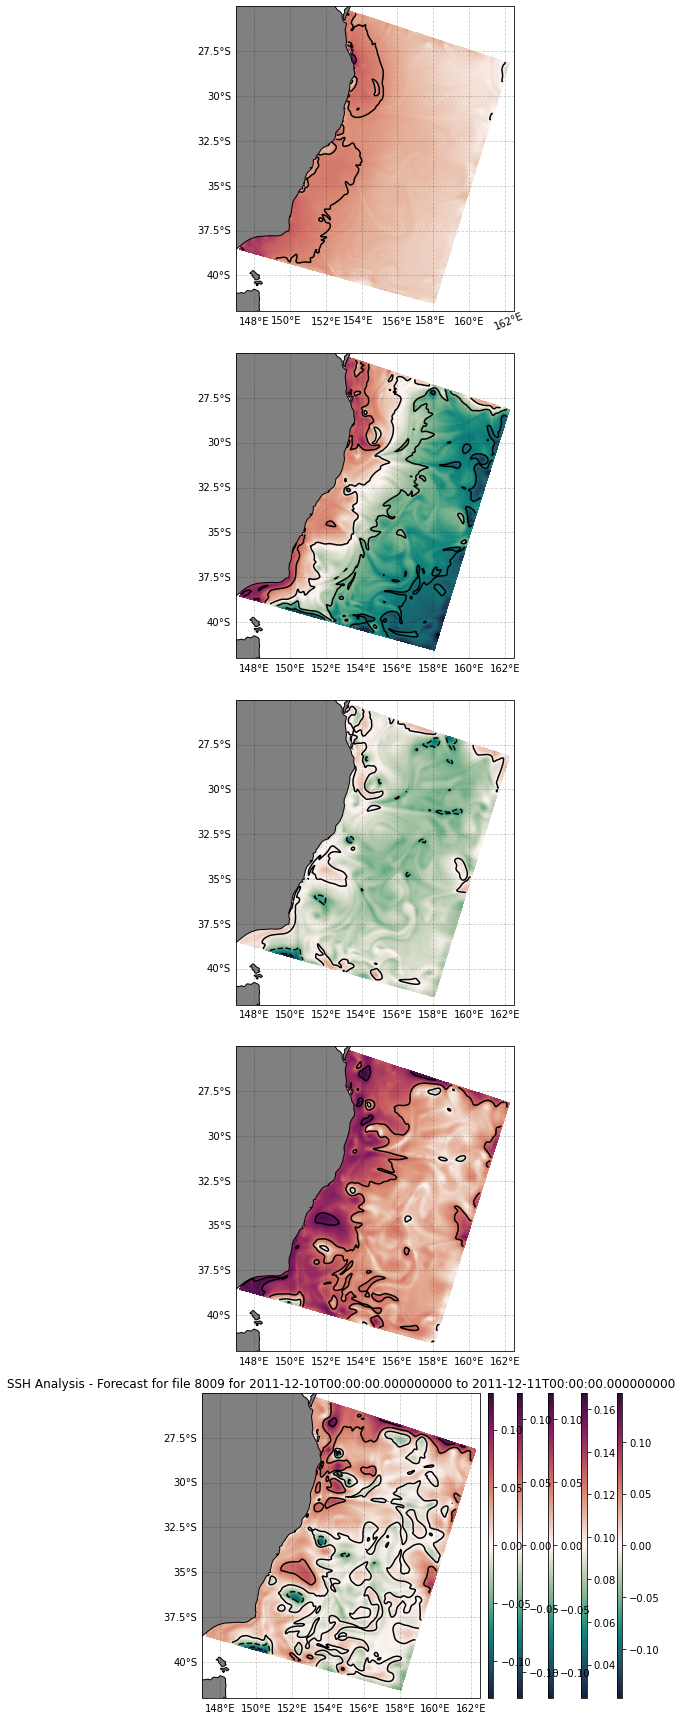

In [51]:


iRangeMetric = [115, 200]
jRangeMetric = [85, 150]
timeRange = [8005, 8013]
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

import glob
chunks = {'ocean_time':1}
# filelist = glob.glob(hisFilePath+'roms_fwd_outer1_0800*.nc')
prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisFilePath+prefixAnalysis+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()

    fig, axes = plt.subplots(5,figsize=(8,24), subplot_kw={'projection': ccrs.PlateCarree()})
    
    for ax, tChunk in zip(axes, range(0,timeOutputMax,timeOutputs)):
        print(ax)
        ## plot of mean difference over days
        toPlotData = xr.concat((sshForecast,sshAnalysis),'diff').diff(dim='diff').isel(diff=0).isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)

        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')

        plt.colorbar(im, pad=0.02, fraction=0.05, aspect=60)

        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
        gl.right_labels = False
        gl.top_labels = False

        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        plt.title('SSH Analysis - Forecast for file '+str(dates)+' for '+date1+' to '+date2)
        plt.ylabel('deg C')
        plt.tight_layout()
        figName = outFigurePath+'SSHdiff_'+str(dates)+'_day'+str(int(tChunk/timeOutputs+1))+'.png'
        plt.savefig(figName,format='png',bbox_inches='tight')

0
1
2
3
4
<ipython-input-41-5e34571978bc>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
0
1
2
3
4
<ipython-input-41-5e34571978bc>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


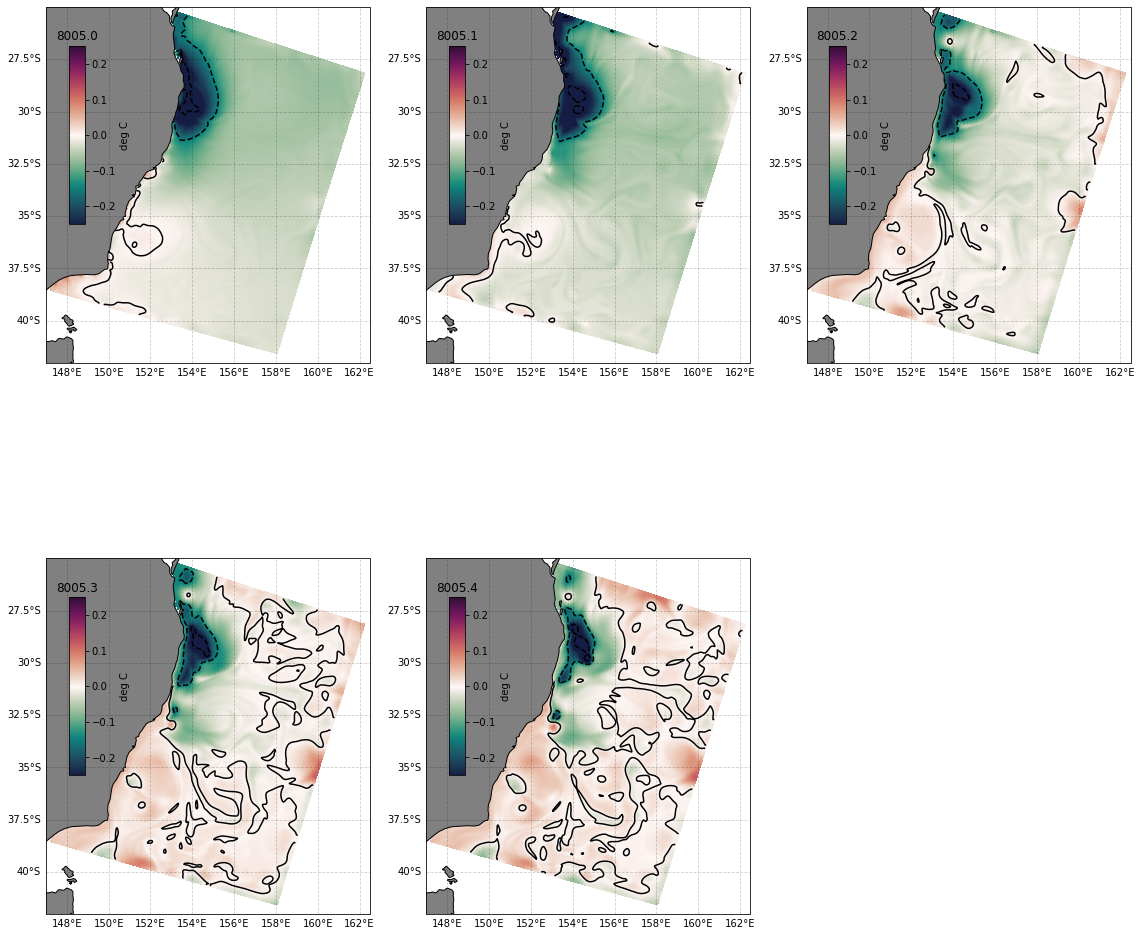

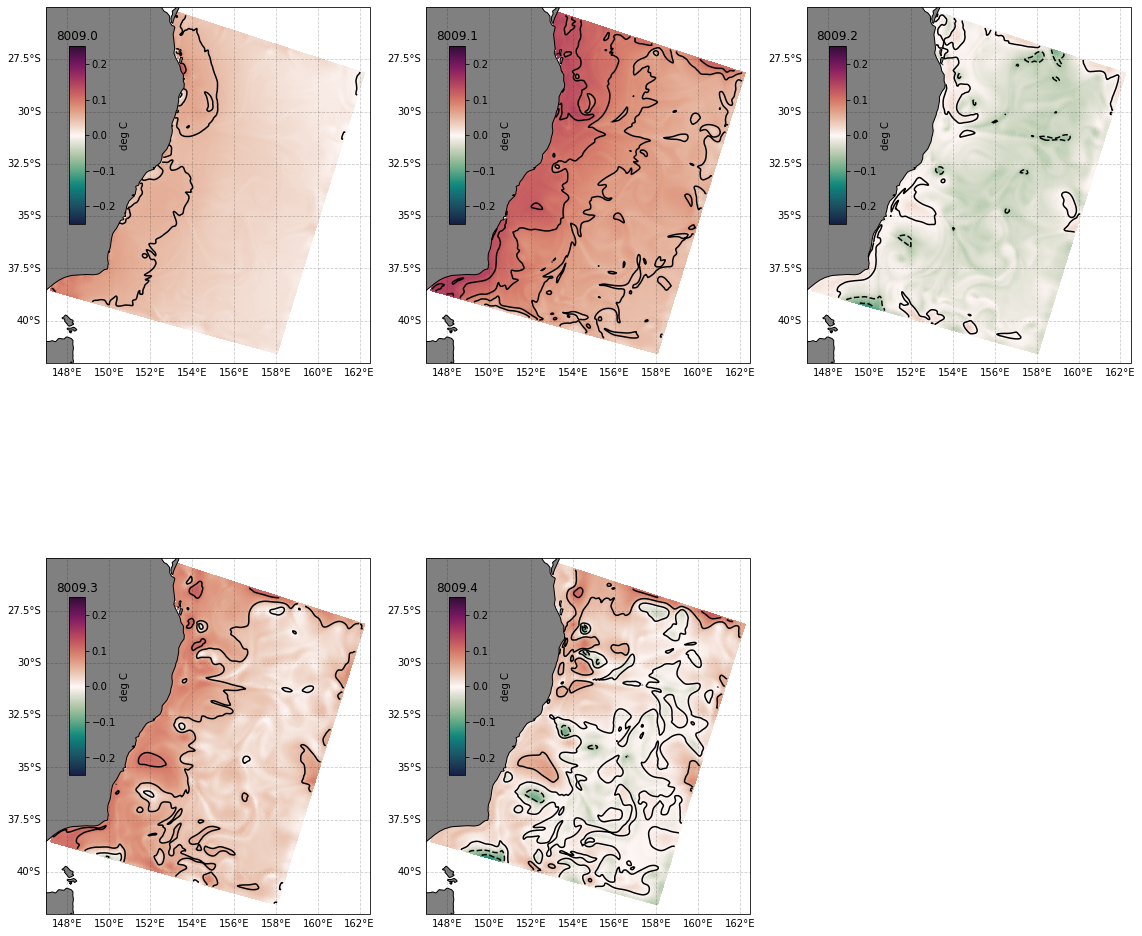

In [41]:


iRangeMetric = [115, 200]
jRangeMetric = [85, 150]
timeRange = [8005, 8013]
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

import glob
chunks = {'ocean_time':1}
# filelist = glob.glob(hisFilePath+'roms_fwd_outer1_0800*.nc')
prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisFilePath+prefixAnalysis+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()

    fig = plt.figure(figsize=(16,16))
    iSz,jSz = (2,3)
    gs = fig.add_gridspec(iSz, jSz)

        
    for ax, tChunk in zip(range(iSz*jSz), range(0,timeOutputMax,timeOutputs)):
        print(ax)
        ## plot of mean difference over days
        toPlotData = xr.concat((sshForecast,sshAnalysis),'diff').diff(dim='diff').isel(diff=0).isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)

        pcol_params={"cmap":"cmo.curl","vmin":-.25, "vmax":.25}#, "add_colorbar":"False"}
        cont_params={"colors":"black"}
        # ax.set_extent([147, 162.5, -42, -25])
        # Plotting
        simple_spatial_plot(toPlotData, ax=ax,pcol_kwargs=pcol_params, cont_kwargs=cont_params)

        # fig.subplots_adjust(right=0.8)
        # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.35])
        # fig.colorbar(im, cax=cbar_ax)

        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        # plt.title('SSH Analysis - Forecast for file '+str(dates)+' for '+date1+' to '+date2)
        plt.title(str(dates)+'.'+str(ax))
        plt.ylabel('deg C')
    plt.tight_layout()
    figName = outFigurePath+'SSHdiff_'+str(dates)+'.png'
    # plt.savefig(figName,format='png',bbox_inches='tight')

0
1
2
3
4
<ipython-input-52-dd79d0394f6c>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
0
1
2
3
4
<ipython-input-52-dd79d0394f6c>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


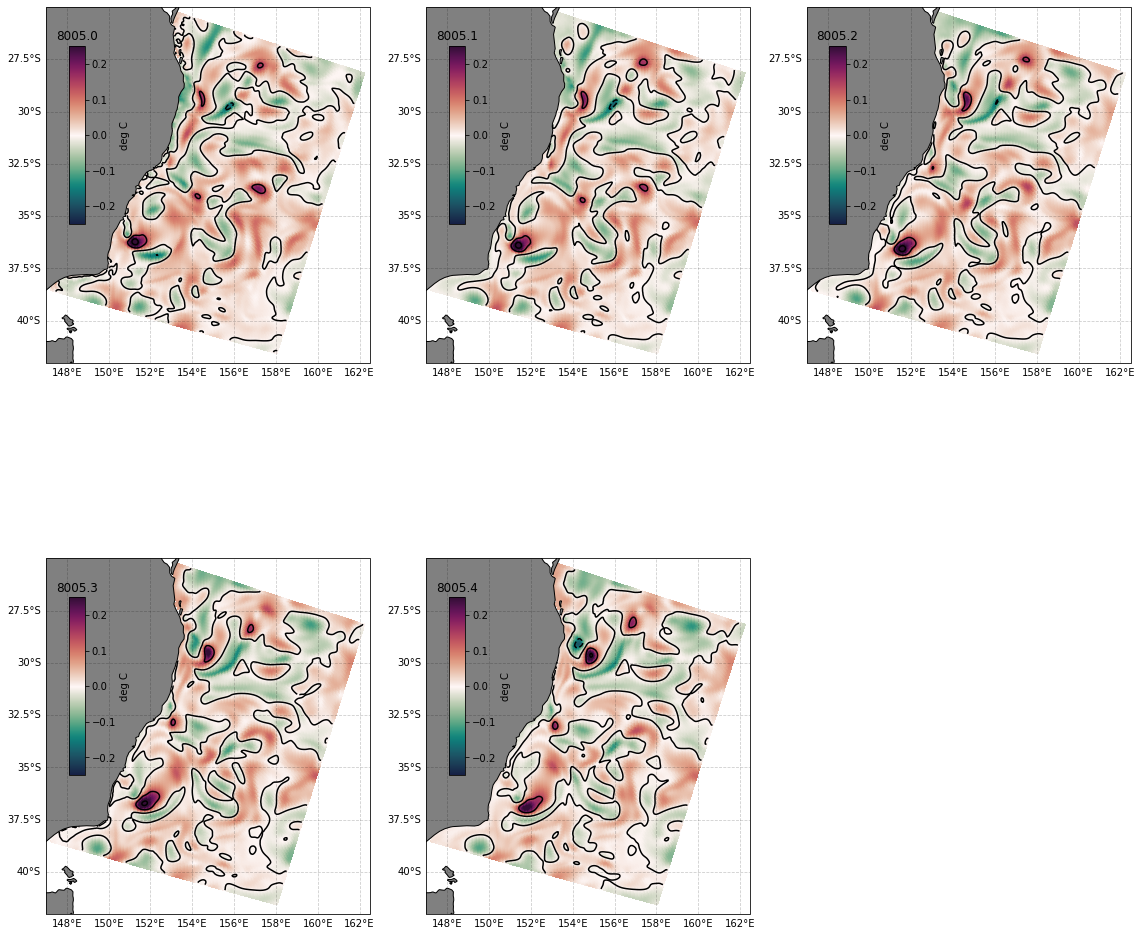

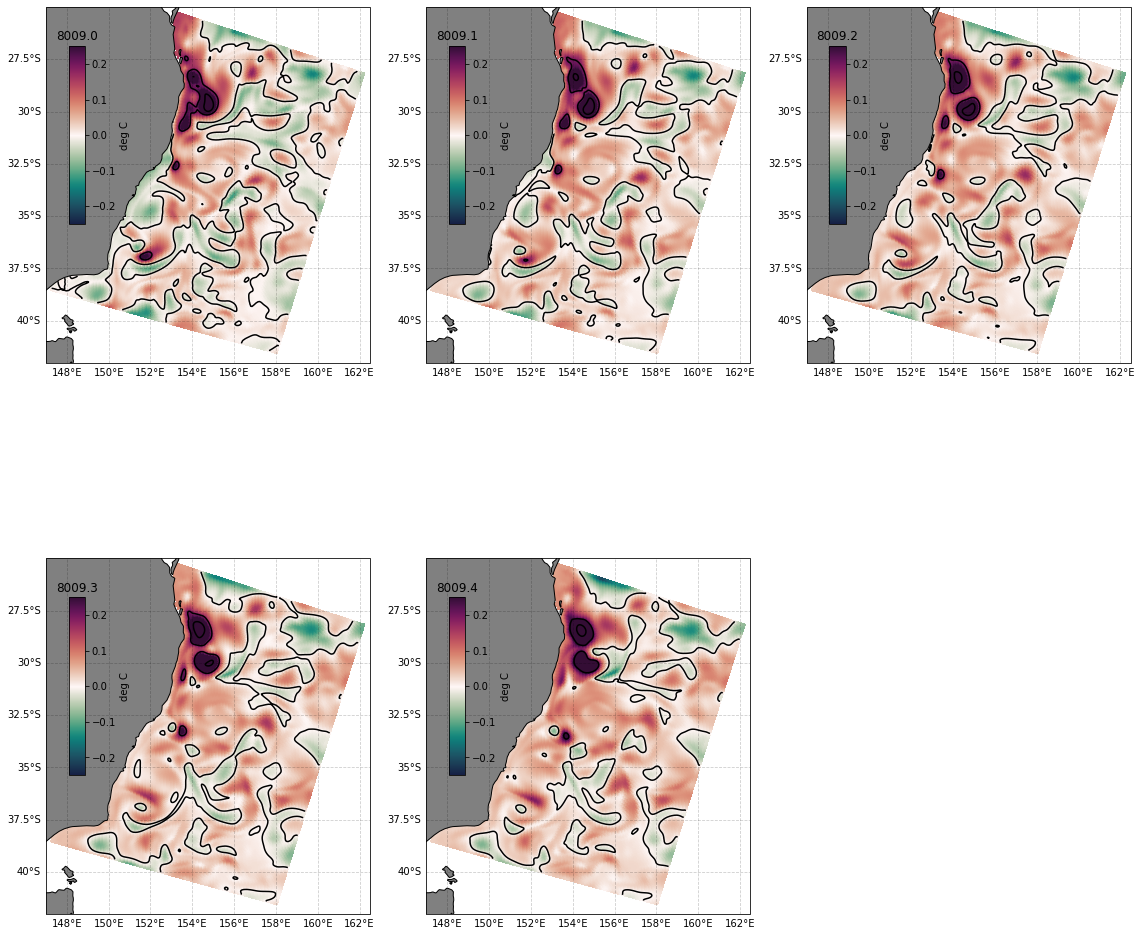

In [52]:


iRangeMetric = [115, 200]
jRangeMetric = [85, 150]
timeRange = [8005, 8013]
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

import glob
chunks = {'ocean_time':1}
# filelist = glob.glob(hisFilePath+'roms_fwd_outer1_0800*.nc')
prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth   =truthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()

    fig = plt.figure(figsize=(16,16))
    iSz,jSz = (2,3)
    gs = fig.add_gridspec(iSz, jSz)

        
    for ax, tChunk in zip(range(iSz*jSz), range(0,timeOutputMax,timeOutputs)):
        print(ax)
        ## plot of mean difference over days
        toPlotData = xr.concat((sshForecast,sshTruth),'diff').diff(dim='diff').isel(diff=0).isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)

        pcol_params={"cmap":"cmo.curl","vmin":-.25, "vmax":.25}#, "add_colorbar":"False"}
        cont_params={"colors":"black"}
        # ax.set_extent([147, 162.5, -42, -25])
        # Plotting
        simple_spatial_plot(toPlotData, ax=ax,pcol_kwargs=pcol_params, cont_kwargs=cont_params)

        # fig.subplots_adjust(right=0.8)
        # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.35])
        # fig.colorbar(im, cax=cbar_ax)

        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        # plt.title('SSH Analysis - Forecast for file '+str(dates)+' for '+date1+' to '+date2)
        plt.title(str(dates)+'.'+str(ax))
        plt.ylabel('m')
    plt.tight_layout()
    figName = outFigurePath+'SSHdiff_'+str(dates)+'.png'
    # plt.savefig(figName,format='png',bbox_inches='tight')

0
1
2
3
4
<ipython-input-53-20315d0a3917>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
0
1
2
3
4
<ipython-input-53-20315d0a3917>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


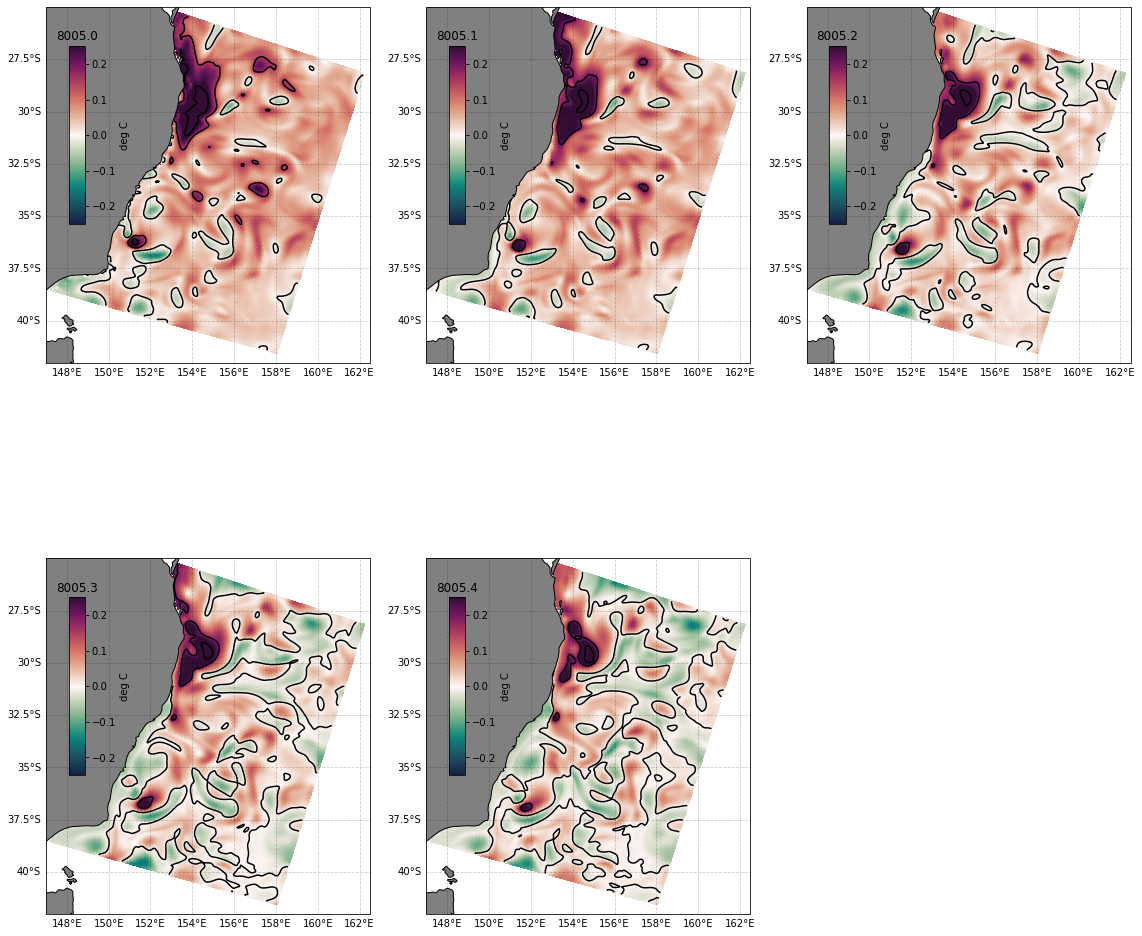

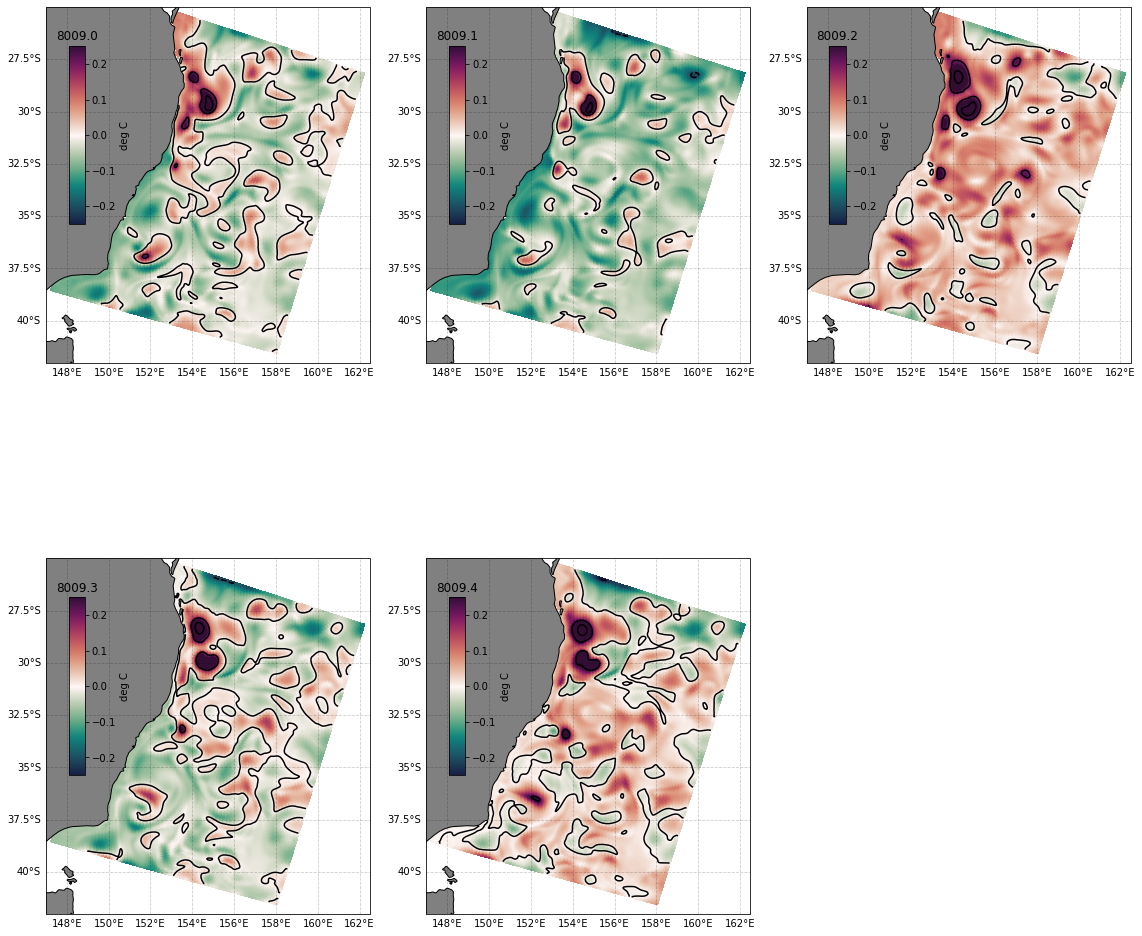

In [53]:


iRangeMetric = [115, 200]
jRangeMetric = [85, 150]
timeRange = [8005, 8013]
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

import glob
chunks = {'ocean_time':1}
# filelist = glob.glob(hisFilePath+'roms_fwd_outer1_0800*.nc')
prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth   =truthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()

    fig = plt.figure(figsize=(16,16))
    iSz,jSz = (2,3)
    gs = fig.add_gridspec(iSz, jSz)

        
    for ax, tChunk in zip(range(iSz*jSz), range(0,timeOutputMax,timeOutputs)):
        print(ax)
        ## plot of mean difference over days
        toPlotData = xr.concat((sshAnalysis,sshTruth),'diff').diff(dim='diff').isel(diff=0).isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)

        pcol_params={"cmap":"cmo.curl","vmin":-.25, "vmax":.25}#, "add_colorbar":"False"}
        cont_params={"colors":"black"}
        # ax.set_extent([147, 162.5, -42, -25])
        # Plotting
        simple_spatial_plot(toPlotData, ax=ax,pcol_kwargs=pcol_params, cont_kwargs=cont_params)

        # fig.subplots_adjust(right=0.8)
        # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.35])
        # fig.colorbar(im, cax=cbar_ax)

        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        # plt.title('SSH Analysis - Forecast for file '+str(dates)+' for '+date1+' to '+date2)
        plt.title(str(dates)+'.'+str(ax))
        plt.ylabel('m')
    plt.tight_layout()
    figName = outFigurePath+'SSHdiff_'+str(dates)+'.png'
    # plt.savefig(figName,format='png',bbox_inches='tight')